Import dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
% matplotlib inline
import numpy as np 
import pandas as pd 
import csv
from sklearn.preprocessing import Imputer


from sklearn.metrics import r2_score

from io import StringIO
#import missingno as msno
import io
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('PDF')
#from StringIO import StringIO
from sklearn import cross_validation,linear_model, metrics, pipeline, preprocessing
from sklearn.preprocessing import FunctionTransformer
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
#from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler  
import calendar
from sklearn.preprocessing import Normalizer, LabelBinarizer

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib notebook

In [3]:
%%javascript
//IPython.OutputArea.auto_scroll_threshold = 9999;

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Import the file.

In [4]:
import timeit
start_time = timeit.default_timer()

In [5]:
raw = pd.read_csv('initial_db.csv')
#Look into the format of the imported data


# Plot histograms to understand data and describe data
datamldb['symmetry_group'].plot.hist(by='symmetry_group')
datamldb['symmetry_group'].describe()
datamldb['zt'].describe()
datamldb.columns.values

In [6]:
# drop tensor values (except _xx)
suffix = ['_yy', '_zz', '_xy', '_xz', '_yz', '_zy', '_yx', '_zx']
dontcare = [variable + s for variable in ['Sigma', 'Kappae', 'Seebeck'] for s in suffix]
db = raw.drop(dontcare, axis=1)

# drop Nan values
db = db.drop(['electrical_resistivity variance', 'electrical_resistivity mean'], axis=1)

# drop meta information
# db = db.drop(['pretty_formula', 'full_formula', 'material_id'], axis=1)

# Delete bogus input material mp-569825
db = db[db.material_id != 'mp-569825']

# Delete all-zero columns
ignore_columns = (db != 0).any(axis=0)
db = db.loc[:, ignore_columns]

# remove linear dependent features
db = db.drop(['Total group #15', 'Total row #8'], axis=1)


In [7]:
db.describe()

,temperature,eV,n_units_in_cell,atomic_mass variance,atomic_mass mean,atomic_radius variance,atomic_radius mean,X variance,X mean,valence_electrons variance,...,Total 5d electrons,density,e_above_hull,symmetry_group,band_gap,Sigma_xx,Kappae_xx,Seebeck_xx,zt,Unnamed: 95
count,87975.000000,8.797500e+04,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,...,87975.000000,87975.000000,87975.000000,87975.000000,87975.000000,8.797500e+04,8.797500e+04,87975.000000,8.797500e+04,0.0
mean,450.000000,2.422993e-18,19.539130,1386.395712,57.316627,0.073806,1.344143,0.085701,1.658856,1.018592,...,0.252174,5.319324,0.022573,150.565217,0.056149,2.014868e+07,2.196639e+02,6.744336,1.130081e-01,NaN
std,216.025918,2.943937e-01,24.304114,1655.596246,27.659541,0.067708,0.138969,0.074767,0.218664,0.417370,...,0.778447,2.462400,0.037993,63.804428,0.166337,3.169648e+07,3.996356e+02,205.362454,4.310242e-01,NaN
min,100.000000,-5.000000e-01,2.000000,1.853791,10.856648,0.000556,1.033333,0.000000,1.150370,0.000000,...,0.000000,1.194592,0.000000,12.000000,0.000000,7.301594e-17,6.899163e-21,-4889.808090,1.308426e-20,NaN
25%,250.000000,-2.600000e-01,7.000000,127.048176,37.850062,0.020000,1.250000,0.016200,1.510000,0.888889,...,0.000000,3.511088,0.000000,63.000000,0.000000,1.809763e+06,1.608211e+01,-15.168533,1.382204e-03,NaN
50%,450.000000,0.000000e+00,9.000000,537.213126,48.490767,0.028711,1.318750,0.079921,1.675000,0.937500,...,0.000000,5.326862,0.000539,180.000000,0.000000,8.055944e+06,7.223950e+01,-0.653704,8.498186e-03,NaN
75%,650.000000,2.600000e-01,24.000000,2803.322503,74.903286,0.114844,1.425000,0.148225,1.820000,1.000000,...,0.000000,6.910636,0.029412,205.000000,0.000000,2.117247e+07,2.225874e+02,15.452140,4.447916e-02,NaN
max,800.000000,5.000000e-01,152.000000,5476.618880,142.732285,0.270000,1.756250,0.249820,2.095000,2.250000,...,4.000000,13.914380,0.150475,225.000000,0.797800,1.840914e+08,1.079191e+04,6923.884040,7.669746e+00,NaN


In [8]:
print(db.shape)
count=0
for i in db:
    print (count,i)
    count=count+1
#print(db.iloc[:,43])    

(87975, 56)
0 pretty_formula
1 full_formula
2 material_id
3 temperature
4 eV
5 n_units_in_cell
6 atomic_mass variance
7 atomic_mass mean
8 atomic_radius variance
9 atomic_radius mean
10 X variance
11 X mean
12 valence_electrons variance
13 valence_electrons mean
14 Total group #1
15 Total group #2
16 Total group #3
17 Total group #4
18 Total group #5
19 Total group #6
20 Total group #7
21 Total group #8
22 Total group #9
23 Total group #10
24 Total group #11
25 Total group #12
26 Total group #14
27 Total row #2
28 Total row #3
29 Total row #4
30 Total row #5
31 Total row #6
32 Total 1s electrons
33 Total 2s electrons
34 Total 2p electrons
35 Total 3s electrons
36 Total 3p electrons
37 Total 4s electrons
38 Total 3d electrons
39 Total 4p electrons
40 Total 5s electrons
41 Total 4d electrons
42 Total 5p electrons
43 Total 6s electrons
44 Total 4f electrons
45 Total 5d electrons
46 density
47 e_above_hull
48 symmetry_group
49 crystal
50 band_gap
51 Sigma_xx
52 Kappae_xx
53 Seebeck_xx
54 z

In [9]:
lb = LabelBinarizer()
i = list(range(3,46)) + [50]
X = np.hstack((db.iloc[:, i].values, lb.fit_transform(db['crystal'])))
y = db['zt'].values
global_i = np.arange(0,X.shape[0])
print(i)
print(X.shape)
print(lb.fit_transform(db['crystal']).shape)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 50]
(87975, 50)
(87975, 6)


In [10]:
dbcopy=db.iloc[:, i].copy()
type(dbcopy)
dbcopy.columns.values

array(['temperature', 'eV', 'n_units_in_cell', 'atomic_mass variance',
       'atomic_mass mean', 'atomic_radius variance', 'atomic_radius mean',
       'X variance', 'X mean', 'valence_electrons variance',
       'valence_electrons mean', 'Total group #1', 'Total group #2',
       'Total group #3', 'Total group #4', 'Total group #5',
       'Total group #6', 'Total group #7', 'Total group #8',
       'Total group #9', 'Total group #10', 'Total group #11',
       'Total group #12', 'Total group #14', 'Total row #2',
       'Total row #3', 'Total row #4', 'Total row #5', 'Total row #6',
       'Total 1s electrons', 'Total 2s electrons', 'Total 2p electrons',
       'Total 3s electrons', 'Total 3p electrons', 'Total 4s electrons',
       'Total 3d electrons', 'Total 4p electrons', 'Total 5s electrons',
       'Total 4d electrons', 'Total 5p electrons', 'Total 6s electrons',
       'Total 4f electrons', 'Total 5d electrons', 'band_gap'], dtype=object)

In [11]:
X=X[np.isfinite(X).all(axis=1)]

In [12]:
#from sklearn import preprocessing
#X =   preprocessing.scale(X)
#IMPORTANT: You should find the mean and variance for each feature separately on your training data. then during training and testing each feature should be reduced by the corresponding mean and be divided by the corresponding standard deviation. So yes, for each feature during testing and training you have to provide same values for mean and std which are obtained using training data. I suggest you taking a look at here.
X_mean = X.mean(axis=0)
X_std  = X.std(axis=0)
X_std[np.where(np.isclose(X_std,0))] = 1
X  = np.apply_along_axis(lambda x:(x-X_mean)/X_std, axis=1, arr=X)
print((X[np.isnan(X).any(axis=1)]))
print((X[np.isinf(X).any(axis=1)]))
print(len((X[np.isfinite(X).all(axis=1)])))



[]
[]
87975


In [13]:
#IMPORTANT Split into training, and testing set

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#print(X_train.shape)
#print(X_test.shape)
i=51*60*15
j=51*77*15
X_train=X[:i,:]
#X_train.append(X[j:,:])
X_train=np.concatenate((X_train,X[j:,:]),axis=0)

X_test=X[i:j,:]
print(type(y),y.shape)

y_train=y[:i]
print(y_train.shape,i)
y_train=np.concatenate((y_train,y[j:]))

y_test=y[i:j]

from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train)

#print(X_train.shape,X_test.shape)
#print(y_train.shape,y_test.shape)
#print(type(y_train))



<class 'numpy.ndarray'> (87975,)
(45900,) 45900


datamldb=datamldb.loc[datamldb['temperature'] == 300]
datamldb.describe()

In [14]:
def scoring(clf,X_train, y_train, score):
    scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=1, scoring = score)
    print (np.median(scores)) #*-1 for negative median score
    return np.median(scores)
#Four metrics: mean_squared_error, mean_absolute_error ('neg_median_absolute_error'), explained_variance_score and r2_score
 

In [15]:
def plot_learning_curve(estimator,outfile,title, X, y, ylim=None, cv=None,n_jobs=3,train_sizes=np.linspace(.1, 1.0, 5),shuffle=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R2 Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    print(train_scores_mean,'train scores mean')
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print(test_scores_mean,'test scores mean')
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training R2 score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation R2 score")

    plt.legend(loc="best")
    plt.savefig(outfile,bbox_inches='tight')
    return (plt,train_sizes, train_scores, test_scores)

In [16]:
def plot_measured_prediction(title,y_test,predicted,out_file):
    fig, ax = plt.subplots()
    ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.title(title)
    plt.savefig(out_file,bbox_inches='tight')
    plt.show()
    return plt

In [17]:
# function takes a model parameter and a ranger and produces a plot and dataframe of CV scores for the parameter values
def evaluate_param(parameter, num_range, index,clf,y_train,X_train):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(X_train, y_train) #[features]
    
    df = {}
#    grid_search.cv
#    for i, score in enumerate(grid_search.grid_scores_):
#        df[score[0][parameter]] = score[1]
 
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    print('means',means,num_range)
#from operator import itemgetter
#paramvalues=map(itemgetter(1),grid_search.cv_results_['params'])
#print('paramvalues',paramvalues)
#grid_search.cv_results_['params'].values()))
    
#    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    plt.subplot(2,2,index)
    plot = plt.plot(num_range,means)
    plt.title(parameter)
    return plot
#    df = pd.DataFrame.from_dict(df, orient='index')
#    df.reset_index(level=0, inplace=True)
#    df = df.sort_values(by='index')
 

## STATISTICS .

def violinplot(data_in,key,target,xlabel,ylabel,title,out_file):
    #col_order = np.sort(data_in[key].unique()).tolist()
    #plt.figure(figsize=(16,6))
    ax=sns.violinplot(x=key, y=target, data=data_in, )#order=col_order IMPORTANT IF TO BE PLOTTED ON UNIQUE VALUES OF OUTPUT.
    #plt.ylim([-100,1000])
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    plt.title(title, fontsize=25)
    #plt.show()
    #ax.set(ylim=(1.5,3))
    plt.savefig(out_file,bbox_inches='tight')
    #plt.show()
    return ax

import seaborn as sns
f,ax=plt.subplots(figsize=(16,6))
#ax.set(ylim=(0,5000))
ax=violinplot(datamldb,'zt','atomic_mass variance','Zt', 'Atomic mass variance','zt vs Variance Atomic mass','VarianceAtomicmassZt.png')
plt.show()

## RANDOM FOREST - EVALUATION, PARAMETER HYPERTUNING, BEST PARAMETER SELECTION, CROSS VALIDATION SCORE, TEST SCORE.

In [18]:
import pickle

rfr = RandomForestRegressor(max_depth=25,n_estimators=30,
#max_depth=50,n_estimators = 100,#max_leaf_nodes=50,
                            #min_samples_leaf = 1,
                            random_state = 42)


rfr = rfr.fit(X_train, y_train)

# SAVE THE MODEL TO DISC
filename = 'finalized_model.sav'
pickle.dump(rfr, open(filename, 'wb'))


importances = rfr.feature_importances_



# LOAD THE MODEL FROM DISC
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)

rfr_preds=[]
rfr_preds = rfr.predict(X_test)

## just checking if loading is accurate
diff=rfr_preds-result
print(np.mean(diff))


##CHECK THE MODEL PERFORMANCE USING R2 SCORE FOR REGRESSION

#result = loaded_model.score(X_test, Y_test)

#medianr2score=scoring(rfr,X_train, y_train,'r2')#'neg_median_absolute_error'
#print ("Random Forest CV error  in eV:", medianr2score)

#title = "Fit measured Vs predicted"
#out_file1=('RFFitPredictionRegressionwooutlier.png')
#plot_measured_prediction(title,y_test,rfr_preds,out_file1)

#y_test=y_test[:,1].ravel()
print ('TEST error R2 Score', r2_score(y_test,rfr.predict(X_test)),'Train error R2 Score',r2_score(y_train,rfr.predict(X_train)))
#print("Random Forest TEST error in MAE:", median_absolute_error(y_test,rfr_preds))


0.0
TEST error R2 Score 0.762526092485 Train error R2 Score 0.999059909211


In [19]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
#          'figure.figsize': (20, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
plt.rcParams['font.size']=18
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [20]:
##BEST PREDICTED MATERIALS
fig,ax = plt.subplots(1,1, figsize=(6,6))
yy_train = rfr.predict(X_train)
yy_test  = rfr.predict(X_test)
s0 = max(np.min(yy_train), np.min(y_train))
s1 = min(np.max(yy_train), np.max(y_train))
ax.plot(y_train, yy_train, 'o ', markeredgewidth=1, markeredgecolor='k')
ax.plot(y_test , yy_test , 'o ', markeredgewidth=1, markeredgecolor='k')
ax.plot([s0,s1], [s0,s1], '--', linewidth=3)
ax.plot(np.zeros(51), np.zeros(51), 'o ', markeredgewidth=1, markeredgecolor='k')
ax.set_xlabel('actual Zt')
ax.set_ylabel('predicted Zt')
ax.legend(['Train (R2- 0.99)', 'Test (R2- 0.76)', 'Perfect fit'])
ax.set_title('Predicted vs actual Zt values')
text=ax.text(2.5,-0.2, "", va="bottom", ha="left")
#annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
#                       bbox=dict(boxstyle="round", fc="w"),
#                       arrowprops=dict(arrowstyle="->"))
#ax[1].plot(np.linspace(-.5,.5,51), np.zeros(51), 'o-', markeredgewidth=1, markeredgecolor='k', color='#d62728')
#ax[1].plot(np.linspace(-.5,.5,51), np.zeros(51), color='#2ca02c')
#ax[1].legend(['Predicted', 'Exact'])
#ax[1].set_xlabel('chemical potential (eV)')
#ax[1].set_ylabel('Figure-of-merit: zt')

train = np.vstack([y_train, yy_train.squeeze()])
test  = np.vstack([y_test,  yy_test.squeeze()] )


<IPython.core.display.Javascript object>

def onclick(event):

    click_xy = np.array([event.xdata, event.ydata])
    dist1 = np.apply_along_axis(lambda x : np.linalg.norm(x-click_xy), axis=0, arr=train)
    dist2 = np.apply_along_axis(lambda x : np.linalg.norm(x-click_xy), axis=0, arr=test)
    i = np.argmin(dist1)
    j = np.argmin(dist2)
    if dist1[i] < dist2[j]:
        mat_id = db['material_id'].iloc[train_i[i]]
        name = 'Train:{} ({}) T={}'.format(db['pretty_formula'].iloc[train_i[i]], db['material_id'].iloc[train_i[i]], db['temperature'].iloc[train_i[i]])
#        annot.set_text('%s'%(db['pretty_formula'].iloc[train_i[i]]))
#db['pretty_formula'].iloc[train_i[i]],db['eV'].iloc[train_i[i]],db['temperature'].iloc[train_i[i]]))       
#        annot.xy = train[:,i]
        k  = train_i[i] // 51
        k  = np.arange(k*51,(k+1)*51)
        k  = np.array([j for j,ii in enumerate(train_i)  if ii in k])
        X0 = X_train[k,:]
        y0 = y_train[k]
    else:
        mat_id = db['material_id'].iloc[test_i[j]]
        name = 'Test:{} ({}) T={}'.format(db['pretty_formula'].iloc[test_i[j]], db['material_id'].iloc[test_i[j]], db['temperature'].iloc[test_i[j]])
#        annot.set_text('%s'%(db['pretty_formula'].iloc[test_i[j]]))
        #db['material_id'].iloc[test_i[j]],db['eV'].iloc[test_i[j]],db['temperature'].iloc[test_i[j]]
#        annot.xy = test[:,j]
        k  = test_i[j] // 51
        k  = np.arange(k*51,(k+1)*51)
        k  = np.array([j for j,ii in enumerate(test_i)  if ii in k])
        X0 = X_test[k,:]
        y0 = y_test[k]

    # k  = np.arange(k*51,(k+1)*51)
    # k1 = np.array([j for j,ii in enumerate(test_i)  if ii in k])
    # k2 = np.array([j for j,ii in enumerate(train_i) if ii in k])
    # X0 = np.vstack((X_test[k1,:], X_train[k2,:])).squeeze()
    # y0 = np.hstack((y_test[k1],   y_train[k2])).squeeze()
    # i  = np.argsort(X0[:,1])
    # X0 = X0[i,:]
    # y0 = y0[i]
    y1 = model.predict(X0).squeeze()
#    ax[1].lines[0].set_ydata(y1)
#    ax[1].lines[1].set_ydata(y0)
#    ax[1].set_ylim([np.min([y0,y1])-0.1, np.max([y0,y1])+.1])
#    ax[1].set_title(name)
    ax.lines[3].set_xdata(y0)
    ax.lines[3].set_ydata(model.predict(X0).squeeze())
    ax.legend(['Train (R2-0.95)', 'Test (R2-0.34)', 'Perfect fit']) 
    # , mat_id
    fig.canvas.draw()
    
fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()


## ARTIFICIAL NEURAL NETWORK

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
m,input_layer_size=X_train.shape
model=Sequential()
model.add(Dense(input_dim=input_layer_size, units=50,activation='tanh'))
model.add(Dense(input_dim=input_layer_size, units=20,activation='sigmoid'))
model.add(Dense(input_dim=input_layer_size, units=10,activation='sigmoid'))
model.add(Dense(input_dim=input_layer_size, units=5,activation='sigmoid'))
                 
#model.add(Dense(  units=10,activation='sigmoid')) 
model.add(Dense(  units=1))
model.compile(optimizer='adam', loss='mean_squared_error') #'mean_squared_error'



#X_train=np.array(X_train)
#X_test=np.array(X_test)
#X = X_train.iloc[:, :].as_matrix()
#y_train = y_train.iloc[:].as_matrix()
print(type(X_train))
print(type(y_train))
lrnn=model.fit(X_train,y_train,batch_size=200,epochs=50,verbose=1,validation_split=0.33) 
nnpredicttrain=model.predict(X_train)
nnpredictest=model.predict(X_test)
lr_msr_train=mean_squared_error(y_train,nnpredicttrain)
lr_msr_test=mean_squared_error(y_test,nnpredictest)
print(lr_msr_train,lr_msr_test)
title = "Fit measured Vs predicted"
out_file1=('DNNFitPredictionRegression.png')
plot_measured_prediction(title,y_test,nnpredictest,out_file1)





#y_test=y_test[:,1].ravel()
#print ("Random Forest TEST error in MSE:", mean_squared_error(y_test0,rfr_preds),'TEST error R2 Score', r2_score(y_test0,rfpredictest))

mu=y_train.mean()
err_train=np.power(y_train-model.predict(X_train).squeeze(),2)
err_mean_model=np.power(y_train-mu,2)
R2train=1 - np.sum(err_train)/np.sum(err_mean_model)

R2train


print(nnpredictest.shape)
mutest=y_test.mean()
err_test=np.power(y_test-model.predict(X_test).squeeze(),2)
err_mean_modeltest=np.power(y_test-mutest,2)
R2test=1 - np.sum(err_test)/np.sum(err_mean_modeltest)

print(R2train,R2test)

#SAVE BAND GAP FOR TEST DATA
datamldb = datamldb.reset_index (drop = True)
test= np.zeros( (len(rfr_preds), 4) )
#Deletion of rows for missing value results in gaps in index number as a result the row number is not equal to index number. so we have reset.
#with open('test.txt','a') as f_handle:
for i in range(len(rfr_preds)):
    ind=indices_test[i]
    abcdeint2=datamldb.loc[ind,'pretty_formula']
    abcdeint3=datamldb.loc[ind,'full_formula']
    abcdeint4=datamldb.loc[ind,'band_gap']
    for j in range(3):
        test[i,j]=[rfr_preds[i],y_test0[i],abcdeint2,abcdeint3,abcdeint4]
#    print(ind, rfr_preds[i], ' ', y_test0[i], ' ',abcdeint2, ' ',abcdeint3, '', abcdeint4)
        #np.savetxt(f_handle, np.c_[rfr_preds[i],y_test0[i],abcdeint2,abcdeint3,abcdeint4],newline='\n',delimiter=",")
    #input("Press Enter to continue...")


In [21]:
dbcopy=dbcopy.rename(index=str, columns={"mu":"eV", "n_units_in_cell": "elements_in_compound"})

In [22]:
#PLOT FEATURE IMPORTANCE
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (12, 4),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
#plt.rcParams['font.size']=18
#plt.rcParams['xtick.labelsize']=18
#plt.rcParams['ytick.labelsize']=18
def plot_importances2(model, model_name): 
    importances = model.fit(X_train, y_train).feature_importances_
    #importances = model.feature_importances_
    
    std = np.std([model.feature_importances_ for feature in model.estimators_])
    indices = np.argsort(importances)[::-1]  
    #print('indices'  ,' Name of column' 'Indice number of importance')
    #print(indices.T,X_train.columns[indices].T,importances[indices].T)
#    plt.figure(figsize = (20,6))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xlim([-1,7])
    plt.xticks(range(X_train.shape[1]),dbcopy.columns[indices[:7]])
    plt.xticks(rotation=90)
    #plt.xticks(range(X_train.shape[1]),indices)
    #plt.xlim([-1, X_train.shape[1]])
    plt.xlim([-1,7])
    plt.savefig('importanceregression.png',bbox_inches='tight')
    plt.show()
#print(estimatorrfr.named_steps["feature_processing"])  
#print("Feature ranking:")

i = 0
for feature in X_train:
    #print (i, feature)
    i += 1
    
plot_importances2(rfr, "Random Forest Regressor")



In [23]:
title = "Learning Curves Random Forest"
out_file1=('RFLCC1.png')
#import matplotlib.pylab as pylab
#params = {'legend.fontsize': 'small',
#          'figure.figsize': (22, 5),
#         'axes.labelsize': 'small',
#         'axes.titlesize':'large',
#         'xtick.labelsize':'large',
#         'ytick.labelsize':'large'}
#pylab.rcParams.update(params)
#plt.rcParams['font.size']=24
#plt.rcParams['axes.labelsize']=24
plt1,train_sizes, train_scores, test_scores=plot_learning_curve(rfr,out_file1,title,X_train,y_train, ylim=None,cv=3,n_jobs=1)



<IPython.core.display.Javascript object>

[ 0.97360599  0.99287094  0.99556454  0.99726111  0.99821762] train scores mean
[ 0.83332804  0.95702528  0.97559641  0.98417669  0.98951793] test scores mean


In [24]:
n_samples = X_train.shape[0]
print(n_samples)
count=0
print(len(range(10,n_samples,10)))
   

74970
7496


#Depth of tree for each tree in random forest

maxdepthlist=[estimator.tree_.max_depth for estimator in grid_cv2.best_estimator_.estimators_]
print (np.max(maxdepthlist))

# TESTING NEW MATERIALS

In [25]:
#print(datamldb2.head)
#print(list(datamldb2.columns.values))

In [26]:
#datamldb2['material_id'].unique()
#datamldb2.loc["mp-10003":"mp-10010","mu"]
db=[]
db2=[]
Xs=[]

In [27]:
raw2 = pd.read_csv('search_list.csv')

# drop tensor values (except _xx)
suffix = ['_yy', '_zz', '_xy', '_xz', '_yz', '_zy', '_yx', '_zx']
dontcare = [variable + s for variable in ['Sigma', 'Kappae', 'Seebeck'] for s in suffix]
db2 = raw2.drop(dontcare, axis=1)

# drop Nan values
db2 = db2.drop(['electrical_resistivity variance', 'electrical_resistivity mean'], axis=1)

# drop meta information
# db = db.drop(['pretty_formula', 'full_formula', 'material_id'], axis=1)

# Delete all-zero columns
db2 = db2.loc[:, ignore_columns.values]

# remove linear dependent features
db2 = db2.drop(['Total group #15', 'Total row #8'], axis=1)

db2.describe()
db2.columns.values

array(['pretty_formula', 'full_formula', 'material_id', 'temperature',
       'eV', 'n_units_in_cell', 'atomic_mass variance', 'atomic_mass mean',
       'atomic_radius variance', 'atomic_radius mean', 'X variance',
       'X mean', 'valence_electrons variance', 'valence_electrons mean',
       'Total group #1', 'Total group #2', 'Total group #3',
       'Total group #4', 'Total group #5', 'Total group #6',
       'Total group #7', 'Total group #8', 'Total group #9',
       'Total group #10', 'Total group #11', 'Total group #12',
       'Total group #14', 'Total row #2', 'Total row #3', 'Total row #4',
       'Total row #5', 'Total row #6', 'Total 1s electrons',
       'Total 2s electrons', 'Total 2p electrons', 'Total 3s electrons',
       'Total 3p electrons', 'Total 4s electrons', 'Total 3d electrons',
       'Total 4p electrons', 'Total 5s electrons', 'Total 4d electrons',
       'Total 5p electrons', 'Total 6s electrons', 'Total 4f electrons',
       'Total 5d electrons', 'density

In [28]:
features = np.array(list(range(3,46)) + [50])
i = list(range(3,46)) + [50]
Xs = np.hstack((db2.iloc[:, i].values, lb.transform(db2['crystal'])))
Xs=Xs[np.isfinite(Xs).all(axis=1)]
# scale input
Xs = np.apply_along_axis(lambda x:(x-X_mean)/X_std, axis=1, arr=Xs)
# print problem size
print('Search space size :', Xs.shape)
print('Training set size :', X.shape)
print('Number of \'inf\' entries: ', np.sum(np.isinf(Xs)))
print('Number of \'isnan\' entries: ', np.sum(np.isnan(Xs)))

Search space size : (240312, 50)
Training set size : (87975, 50)
Number of 'inf' entries:  0
Number of 'isnan' entries:  0


<IPython.core.display.Javascript object>


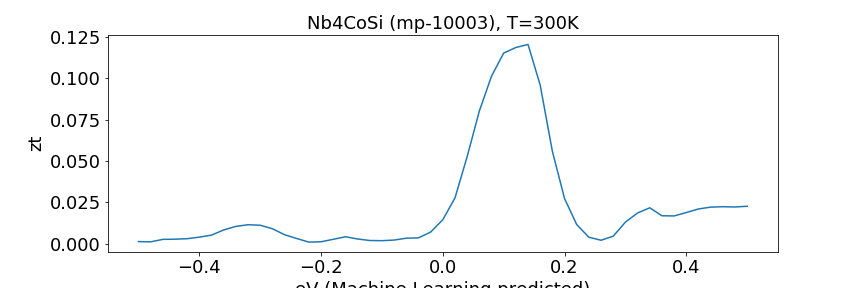

Text(0,0.5,'zt')

In [30]:
eV = np.linspace(-.5,.5, 51)
y1 = rfr.predict(Xs[:51,:])
fig,ax = plt.subplots(1,1)
plt.plot(eV, y1) # *dy+ymin)
plt.title('{} ({}), T=300K'.format(raw2['pretty_formula'].iloc[0], raw2['material_id'].iloc[0]))
plt.xlabel('eV (Machine Learning predicted)')
plt.ylabel('zt')

[  2040 215322  13974 215271  57987 215373 208539   2142]
[ 2.97924072  2.98235548  3.00049819  3.02589033  3.05557149  3.07941382
  3.07941382  3.09399423]


<IPython.core.display.Javascript object>


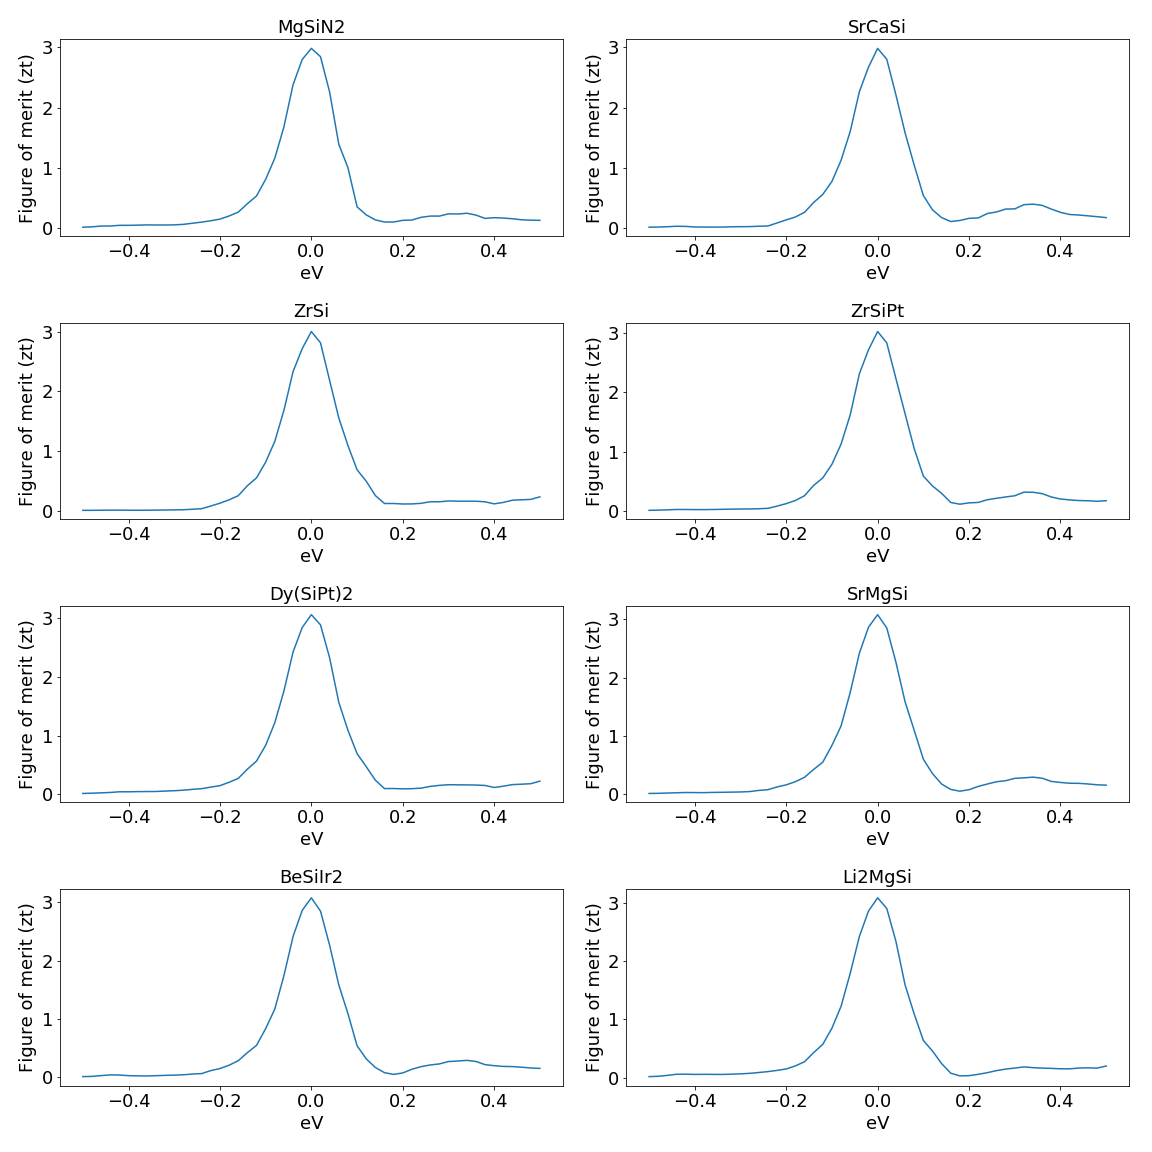

In [31]:
i = 0
n = 8
best_i = np.array([], dtype=np.int)
best_y = np.array([])
while i<Xs.shape[0]:
#    print(i)
    y = rfr.predict(Xs[i:i+51,:]).squeeze()
    # y = y[20:30]
    if len(best_y) < n:
        best_i = np.append(best_i, i)
        best_y = np.append(best_y, np.max(y))
        j = np.argsort(best_y)
        best_i = best_i[j]
        best_y = best_y[j]
    elif np.max(y) > best_y[0]:
        best_y[0] = np.max(y)
        best_i[0] = i
        j = np.argsort(best_y)
        best_i = best_i[j]
        best_y = best_y[j]
    i += 51

print(best_i)
print(best_y)
best = []
fig,ax = plt.subplots(n//2,2, figsize=(16,16))
for j,i in enumerate(best_i):
    y = rfr.predict(Xs[i:i+51,:]).squeeze()
    
    ax[j//2,j%2].plot(eV, y) #*dy+ymin)
#    ax[j//2,j%2].set_title('{} ({}), T=300K'.format(raw2['pretty_formula'].iloc[i], raw2['material_id'].iloc[i]))
    ax[j//2,j%2].set_title('{}'.format(raw2['pretty_formula'].iloc[i]))
    ax[j//2,j%2].set_xlabel('eV')
    ax[j//2,j%2].set_ylabel('Figure of merit (zt)')
    best.append(raw2['material_id'].iloc[i])
plt.tight_layout()

In [43]:
i = 0
best = []
ya=[]
mu=[]
rfr_preds = rfr.predict(Xs).squeeze()        
#fig=plt.figure()   
print(len(rfr_preds))
print(np.argsort(rfr_preds)[-8:])
print('')
for i in np.argsort(rfr_preds)[-8:]:
#    print(i)
    ya.append(rfr_preds[i])
    mu.append(raw2['eV'].iloc[i])
    best.append(raw2['full_formula'].iloc[i])

    
print(best)
print('')
np.set_printoptions(precision=3)

print(np.around(ya,4))
print('')
print(mu)
print('')


240312
[  2065 215347  13999 215296  58012 208564 215398   2167]

['Mg1Si1N2', 'Sr1Ca1Si1', 'Zr2Si2', 'Zr1Si1Pt1', 'Dy1Si2Pt2', 'Be1Si1Ir2', 'Sr1Mg1Si1', 'Li2Mg1Si1']

[ 2.979  2.982  3.001  3.026  3.056  3.079  3.079  3.094]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



In [33]:
elapsed = timeit.default_timer() - start_time
print(elapsed)

71180.83468492515


print(len(best))

plt.figure(1)
ax = plt.subplot(111)
bestunique=np.unique(best)
#colors=np.zeros(len(bestunique))
#print(colors)
#colors=np.zeros(shape=(len(bestunique),3))
colors=['green','blue','black','pink','orange','red','grey','cyan']
print(colors)
labels=np.zeros(shape=(len(bestunique)))
#for i in range(len(bestunique)):
#    colors[i,:]=np.sqrt(np.random.rand(3)*np.random.rand(3))   
markers = range(len(bestunique))#['x', 'o', '^','+', 'o', '*']
for i in range(len(mu)):
    for j in range(len(bestunique)):
        if (best[i]== bestunique[j]):
#            labels[j]=bestunique[j]
            plt.scatter(mu[i],ya[i],label=bestunique[j],marker='o',s=75,color=colors[j]) #markers[j]
#            plt.legend(bestunique[j],bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Machine learning predicted thermoelectric material at room temperature')
plt.xlabel('Chemical Potential')
plt.ylabel('Figure of merit (zt)')
#plt.legend(bestunique)#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
plt.legend()
plt.savefig('mlpredict5.png')




print(colors)